In [1]:
!rm -rf pytorch_utils
!rm -rf IMagenet
!git clone https://github.com/toniqapps/pytorch_utils.git
!git clone https://github.com/toniqapps/IMagenet.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 145 (delta 83), reused 49 (delta 21), pack-reused 0
Receiving objects: 100% (145/145), 46.59 KiB | 627.00 KiB/s, done.
Resolving deltas: 100% (83/83), done.
Cloning into 'IMagenet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 121845 (delta 4), reused 0 (delta 0), pack-reused 121836
Receiving objects: 100% (121845/121845), 213.17 MiB | 27.19 MiB/s, done.
Resolving deltas: 100% (1941/1941), done.
Checking out files: 100% (240610/240610), done.


In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 122kB 9.2MB/s 
     |████████████████████████████████| 952kB 19.2MB/s 
albumentations==0.4.6 is successfully installed


In [3]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

import time
import scipy.ndimage as nd
import imageio

import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
#load tiny image net data (train-70%, test-30%)
from IMagenet import dataset
train, test = dataset.tiny_imagenet_albumentations('IMagenet/tiny-imagenet-200-70-30/', 'new_train', 'new_test')

In [5]:
# !zip -r /content/tiny-imagenet-200-70-20.zip /content/IMagenet/tiny-imagenet-200
# from google.colab import files
# files.download("/content/tiny-imagenet-200-70-20.zip")

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [7]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

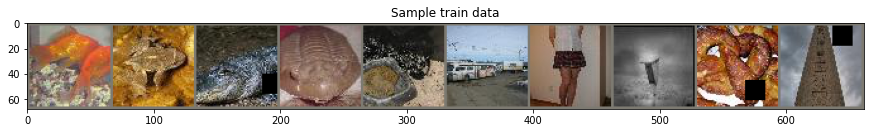

In [8]:
def denormalize(tensor, mean=[0.4914, 0.4822, 0.4465],
						std=[0.2023, 0.1994, 0.2010]):
	single_img = False
	if tensor.ndimension() == 3:
		single_img = True
		tensor = tensor[None,:,:,:]

	if not tensor.ndimension() == 4:
	    raise TypeError('tensor should be 4D')

	mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	ret = tensor.mul(std).add(mean)
	return ret[0] if single_img else ret
  
def imshow(img, title):
	img = denormalize(img)
	npimg = img.numpy()
	fig = plt.figure(figsize=(15,7))
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.title(title)
 
def show_samples():
		# get some random training images
		dataiter = iter(trainloader)
		images, labels = dataiter.next()
		index = []
		num_img = min(200, 10)
		for i in range(num_img):
			for j in range(len(labels)):
				if labels[j] == i:
					index.append(j)
					break
		if len(index) < num_img:
			for j in range(len(labels)):
				if len(index) == num_img:
					break
				if j not in index:
					index.append(j)
		imshow(torchvision.utils.make_grid(images[index],
				nrow=num_img, scale_each=True), "Sample train data")
  
show_samples()


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [10]:
from torchsummary import summary
from IMagenet import model

net = model.IMAGENET_RESNET_S12(model.BasicBlock, [2, 2, 2, 2], num_classes=200).to(device)
summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()
 
train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict())
    scheduler.step()
    te_loss, te_acc = test.test(net, device, testloader, criterion)

    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.553002834320068 Batch_id=300 Accuracy=3.06: 100%|██████████| 301/301 [05:12<00:00,  1.04s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 1722/33000 (5.22%)

EPOCH: 1


Loss=3.857748508453369 Batch_id=300 Accuracy=11.23: 100%|██████████| 301/301 [05:17<00:00,  1.05s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 4938/33000 (14.96%)

EPOCH: 2


Loss=3.385568141937256 Batch_id=300 Accuracy=19.36: 100%|██████████| 301/301 [05:17<00:00,  1.05s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 5761/33000 (17.46%)

EPOCH: 3


Loss=3.336280584335327 Batch_id=300 Accuracy=25.96: 100%|██████████| 301/301 [05:17<00:00,  1.05s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 8203/33000 (24.86%)

EPOCH: 4


Loss=2.8337666988372803 Batch_id=300 Accuracy=31.56: 100%|██████████| 301/301 [05:17<00:00,  1.05s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 9702/33000 (29.40%)

EPOCH: 5


Loss=2.6035525798797607 Batch_id=300 Accuracy=36.12: 100%|██████████| 301/301 [05:17<00:00,  1.06s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10277/33000 (31.14%)

EPOCH: 6


Loss=2.3257193565368652 Batch_id=300 Accuracy=40.07: 100%|██████████| 301/301 [05:17<00:00,  1.05s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 11745/33000 (35.59%)

EPOCH: 7


Loss=2.427703380584717 Batch_id=300 Accuracy=43.38: 100%|██████████| 301/301 [05:17<00:00,  1.05s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 11007/33000 (33.35%)

EPOCH: 8


Loss=2.2892491817474365 Batch_id=300 Accuracy=46.35: 100%|██████████| 301/301 [05:17<00:00,  1.05s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 11033/33000 (33.43%)

EPOCH: 9


Loss=2.142059803009033 Batch_id=185 Accuracy=49.79:  61%|██████▏   | 185/301 [03:16<02:02,  1.05s/it] 